In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

<ipython-input-17-5db40fe4c329>:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


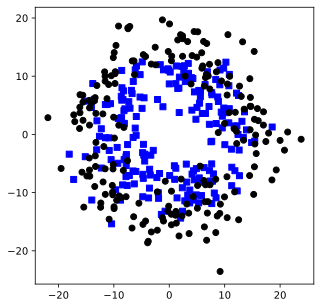

In [18]:
nperclust = 200
th = np.linspace(0,4*np.pi,nperclust)
r1 = 10
r2 = 15
a = [ r1*np.cos(th)+np.random.randn(nperclust)*3,
     r1*np.sin(th)+np.random.randn(nperclust)*3]
b = [ r2*np.cos(th)+np.random.randn(nperclust)*3,
     r2*np.sin(th)+np.random.randn(nperclust)*3]

labels_np = np.vstack((np.zeros((nperclust,1)),np.ones((nperclust,1))))
data_np = np.hstack((a,b)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

fig = plt.figure(figsize = (5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')


In [19]:
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=.2)
train_data = TensorDataset(train_data.float(),train_labels.float())
test_data = TensorDataset(test_data.float(),test_labels.float())
batchsize = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle = True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [20]:
class modelclass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()
    self.input = nn.Linear(2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128,1)
    self.dr = dropoutRate
  def forward(self,x):
    x = F.relu(self.input(x))
    x = F.dropout(x,p= self.dr,training=self.training)
    x = F.relu(self.hidden(x))
    x = F.dropout(x,p= self.dr,training=self.training)
    x = self.output(x)
    return x

In [21]:
def createANewModel(dropoutrate):
  ANNqc = modelclass(dropoutrate)
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(ANNqc.parameters(),lr = .002)
  return ANNqc,lossfun,optimizer

In [22]:
numepochs = 1000
def trainmodel(ANNqc,lossfun,optimizer):
  trainAcc = []
  testAcc = []
  for epochi in range(numepochs):
    ANNqc.train()
    batchAcc = []
    for x,y in train_loader:
      x,y = x.float(),y.float()
      yHat = ANNqc(x)
      loss = lossfun(yHat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchAcc.append(100*torch.mean(((yHat>.5)==y).float()).item())
    trainAcc.append(np.mean(batchAcc))
    ANNqc.eval()
    x,y = next(iter(test_loader))
    yHat = ANNqc(x)
    testAcc.append(100*torch.mean(((yHat>.5)==y).float()).item())
  return trainAcc,testAcc

In [23]:
dropoutrate = .0
ANNqc,lossfun,optimizer = createANewModel(dropoutrate)
trainAcc,testAcc = trainmodel(ANNqc,lossfun,optimizer)

In [24]:
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

Text(0.5, 1.0, 'Dropout rate = 0')

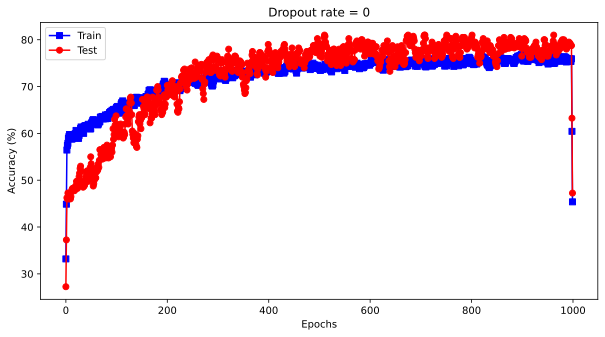

In [26]:
fig = plt.figure(figsize = (10,5))
plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

In [27]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))
for di in range(len(dropoutRates)):
  ANNqc,lossfun,optimizer = createANewModel(dropoutRates[di])
  trainAcc,testAcc = trainmodel(ANNqc,lossfun,optimizer)
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])

Text(0, 0.5, 'Train Test difference(acc%)')

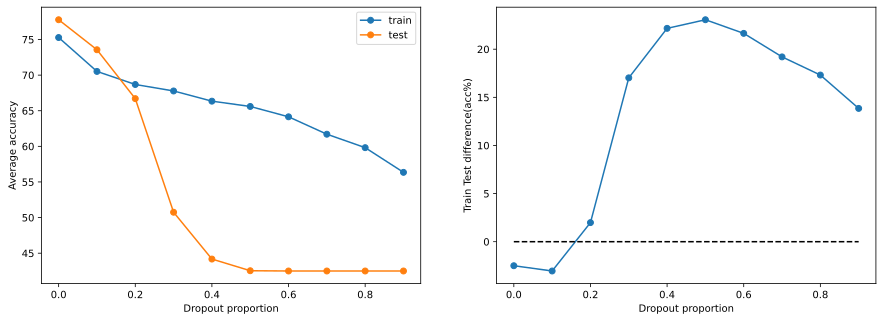

In [30]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['train','test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train Test difference(acc%)')

